### 特征缩放

- 问题：为什么特征的大小尺度很不一样，会导致梯度下降算法变慢？ 为什么把特征缩放到同一个范围内，比如[-1,1],[0,1]会解决梯度下降算法变慢的问题？（从直觉上理解即可）

 1. 线性模型与贡献项

对于多特征线性模型
$$
\hat{y}= w_1x_1+w_2x_2+\dots+w_nx_n+b,
$$

* **每一项 $w_jx_j$** 都在为预测值贡献“加权分数”。
* 如果 $x_j$ 的取值范围比其他特征大得多（如 0 – 3000），那么 **同样大小的权重 $w_j$** 会让这一项产生 **远超其他项** 的数值贡献。

  * 例：面积 $x_1=2000$、卧室数 $x_2=3$。即使 $w_1=w_2=1$，也会有 $w_1x_1 =2000$ 与 $w_2x_2 =3$ 的悬殊差距。
  * 这样会导致预测值几乎只由面积控制，梯度也会优先生长或压缩 $w_1$，其余权重更新“存在感”微弱。


2. 损失函数对“大贡献项”的“惩罚”

以平方损失为例

$$
J(\mathbf{w},b)=\frac1{2m}\sum_{i}( \hat{y}^{(i)}-y^{(i)})^2.
$$

* 如果某个特征项 $w_jx_j$ 过大，$\hat{y}$ 很容易被它**推离**真值 $y$，损失急剧上升。
* 因为损失对误差 $e$ **平方放大**，优化器为了迅速降低 $J$，会对引起大误差的那一项**优先下手**：

  $$
  \frac{\partial J}{\partial w_j}=\frac1m\sum_i e^{(i)}x_j^{(i)}.
  $$

  * 这里的梯度与 $x_j$ **成正比**，数值范围大的特征让梯度也变大，从而导致 **更激进的权重更新**。
* 结果就是：

  * **陡峭方向（大特征）** → 梯度巨大 → 权重调整幅度大，为了抑制贡献而被“拉回”。
  * **平缓方向（小特征）** → 梯度较小 → 权重缓慢更新。
* 在相同学习率 $\alpha$ 下，参数向量会先在陡峭方向来回“过冲—回拉”，同时沿平缓方向慢慢滑动——蜿蜒的轨迹。


3. 为什么缩放能“抚平”这种差距？

    **统一量级后**，所有 $x_j$ 大约落在 $[-1,1]$ 或 $[0,1]$：

    * $\partial J / \partial w_j$ 的幅度不会因为“谁更大”而相差几百倍。
     * 各方向步长相近 → 更新轨迹趋向**径向直线**，收敛速度显著提升。

4. 小结

* **大的特征 $\bigl(x_j \gg x_k\bigr)$**：

  * 同样的权重会导致 **预测贡献极大**，损失函数随之陡峭。
  * 为了快速降损失，优化器会对该权重 **过度惩罚/大幅摆动**——看似把 $w_j$ “限制” 在较小值。
* **梯度 zig‑zag** 本质：

  * 在陡峭（大特征）方向剧烈跳跃，在平缓（小特征）方向慢慢爬坡。
* **解决方式**：
   特征缩放 / 标准化


> **总结**：
> 线性模型里，特征值越大，权重微小变动就能放大误差；损失函数因此“惩罚”它、梯度猛拉它，形成陡峭与平缓方向的极端差异，导致梯度下降之字形前进——缩放后地形变圆，更新才会顺畅。


#### 特征缩放的实现
1. 除以最大值
2. 均值归一化（Mean normalization）
3. Z-score标准化（Z-score normalization）

In [8]:
import numpy as np

# 原始特征矩阵：每行一个样本，列 0=面积，列 1=卧室数
X = np.array([
    [2104, 5],
    [1416, 3],
    [ 852, 2]
], dtype=float)
print("原始 X:\n", X)

# 1. 按最大值缩放
X_max = X / X.max(axis=0)        # 按列除以各自的最大值
print("\n按最大值缩放:\n", X_max)
# 做法：每个特征值除以该列最大值。
# 范围：[0,1] 若所有值 ≥ 0。
# 特点实现最简单，但如果后续出现大于训练集最大值的样本，缩放后值会超出 1。

# 2. 均值归一化
X_mean = (X - X.mean(axis=0)) / (X.max(axis=0) - X.min(axis=0))
print("\nMean normalization:\n", X_mean)
# 做法：先减去列均值，再除以列范围（max-min）
# 范围：大约落在[-1,1]
# 特点：居中到0，且保留相对大小；若分布极端偏斜，效果可能一般。

# 3. Z‑Score 标准化
x_zscore = (X - X.mean(axis=0)) / X.std(axis=0)
print("Z-score 标准化:", x_zscore)
# 做法：减去均值，再除以标准差。
# 范围：均值0，标准差1；数值可正可负，通常在[-3,3]区间
# 特点：对正态分布型（或近似）数据最友好，常用的缩放方法

原始 X:
 [[2.104e+03 5.000e+00]
 [1.416e+03 3.000e+00]
 [8.520e+02 2.000e+00]]

按最大值缩放:
 [[1.         1.        ]
 [0.6730038  0.6       ]
 [0.40494297 0.4       ]]

Mean normalization:
 [[ 0.51650692  0.55555556]
 [-0.03301384 -0.11111111]
 [-0.48349308 -0.44444444]]
Z-score 标准化: [[ 1.26311506  1.33630621]
 [-0.08073519 -0.26726124]
 [-1.18237987 -1.06904497]]


- 什么时候考虑缩放数据？
| 原始特征范围                     | 评估      | 操作建议        |
| -------------------------- | ------- | ----------- |
| $0 \le x_1 \le 3$          | ✅ 范围小   | **不用缩放**    |
| $-2 \le x_2 \le 0.5$       | ✅ 居中且适中 | **不用缩放**    |
| $-100 \le x_3 \le 100$     | ⚠️ 过大   | **需缩放**     |
| $-0.001 \le x_4 \le 0.001$ | ⚠️ 过小   | **需放大/标准化** |
| $98.6 \le x_5 \le 105$     | ⚠️ 偏大   | **需缩放**     |

### 确保梯度下降在**正常工作**

| 目标       | 说明                                                                |
| -------- | ----------------------------------------------------------------- |
| **优化目标** | 最小化代价函数 $J(\mathbf{w}, b)$                                        |
| **学习曲线** | 每一次迭代都应使 $J(\mathbf{w}, b)$ **递减**                                |

> 迭代次数的需求差异很大：30、1 000 甚至 100 000 步都可能出现，取决于学习率和问题规模。



#### 自动收敛判定（伪代码）

```text
设 ε = 1e-3  (收敛阈值)

若  J(t−1) − J(t)  ≤ ε:
    判定为收敛
    -> 已找到使 J 接近全局最小的 (w, b)
```

* **核心思想**：若一次迭代带来的代价下降幅度不超过 ε（例如 0.001），说明模型已基本到达最低点附近，可停止训练。



> **实践提醒**
>
> * 学习率过大：$J$ 可能震荡甚至上升。
> * 学习率过小：$J$ 虽下降，但收敛速度慢，曲线“拖尾”。
> * 建议在训练中实时绘制 **学习曲线**，以及设置 ε‑收敛检验，以便动态调整超参数。


### 选择学习率
1. 如何判断梯度下降是否“出问题”  — 学习率与 Bug 的快速排查

| 现象                         | 可能原因                                                                                | 应对策略                                 |
| -------------------------- | ----------------------------------------------------------------------------------- | ------------------------------------ |
| **锯齿状上下波动**<br/>（但总体仍缓慢下降） |  - 学习率 α 偏大，更新步长过猛，在谷底两侧来回跳 ↔                                                        | ↓ **减小 α**，直至曲线平滑单调降低                |
| **J 指数级上升**                |   1. **符号写反**：<br/> `w = w + α · ∂J` ❌<br/> 应写 `w = w − α · ∂J` ✅<br/>2. **α 远大于最优值** | - 先检查代码是否忘记减号<br/>- 若逻辑无误，显著**调小 α** |
| **J 单调下降，但非常慢**            |  学习率 **过小**，每步只挪一点点                                                                  | ↑ **逐步增大 α**，观察到平滑但更陡的下降即可           |


- 总结：
    1. **先看学习曲线**：若 $J(\mathbf{w},b)$ 每次迭代都应下降；出现震荡或上升即有问题。
    2. **排 Bug**：确认更新公式是 **“减去”** 梯度，而非加。
    3. **调学习率**：

   * 震荡/爆炸 → **减小 α**
   * 缓慢爬坡 → **增大 α**
    4. **经验法则**：找到一个让 $J$ 在每步稳步下降、且下降速度尽可能快的 α；再配合 ε 收敛检测，既高效又安全。


2. 学习率选择简单策略

<img alt="学习率选择" height="600" src="./images/监督学习-回归9.png" width="600"/>


### 特征工程

- 使用直觉，和对数据+业务的理解，设计新的特征
- 新的特征通过对原始特征转换，或者组合原始的特征得到
- 特征工程 + 线性回归 可以得出不仅仅对数据拟合直线，可以拟合多项式曲线

![特征工程后的多项式回归](./images/监督学习-回归10.png)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math
np.set_printoptions(precision=2)

In [21]:
# 使用梯度下降算法
def gradient_descent(X, y,  alpha, iterations):
    """
    批量梯度下降（Batch Gradient Descent）
    --------------------------------------
    循环执行 iterations 轮参数更新，通过梯度下降学习权重 w 与偏置 b。

    参数
    ----
    X : ndarray (m, n)
        训练数据，m 行样本、n 列特征
    y : ndarray (m,)
        目标值（标签）
    alpha : float
        学习率
    iterations : int
        梯度下降的迭代次数

    返回值
    ------
    w : ndarray (n,)
        训练完毕后的权重向量
    b : 标量
        训练完毕后的偏置
    J_history : list
        每一次迭代计算得到的代价，用于绘图或分析
    """

    def cost_function(X, y, w, b):
        m = X.shape[0]
        err = np.dot(X, w) + b - y
        return np.sum(err**2) / (2*m)

    def gradient_function(X, y, w, b):
        m,n = X.shape
        err = np.dot(X,w) + b - y
        dj_dw = X.T @ err / m
        dj_db = np.sum(err) / m
        return dj_dw, dj_db

    # 用于记录每次迭代的 J 以及 w，方便后续绘图
    _, n = X.shape
    J_history = []
    w = np.zeros((n,))
    b = 0

    for i in range(iterations):

        # 计算梯度，并更新参数
        dj_dw, dj_db = gradient_function(X, y, w, b)

        # 梯度下降：按照学习率 alpha 更新 w 和 b
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # 记录当前代价（防止资源耗尽，只保存前 100000 步）
        if i < 100000:
            J_history.append(cost_function(X, y, w, b))

        # 每迭代总次数的 1/10 打印一次代价
        if i % math.ceil(iterations / 10) == 0:
            print(f"迭代 {i:4d} 次：代价 {J_history[-1]:8.2f}")

    # 返回最终参数和代价历史，便于绘图
    return w, b, J_history

迭代    0 次：代价  1657.56
迭代  100 次：代价   694.55
迭代  200 次：代价   588.48
迭代  300 次：代价   526.41
迭代  400 次：代价   490.10
迭代  500 次：代价   468.86
迭代  600 次：代价   456.43
迭代  700 次：代价   449.16
迭代  800 次：代价   444.90
迭代  900 次：代价   442.41


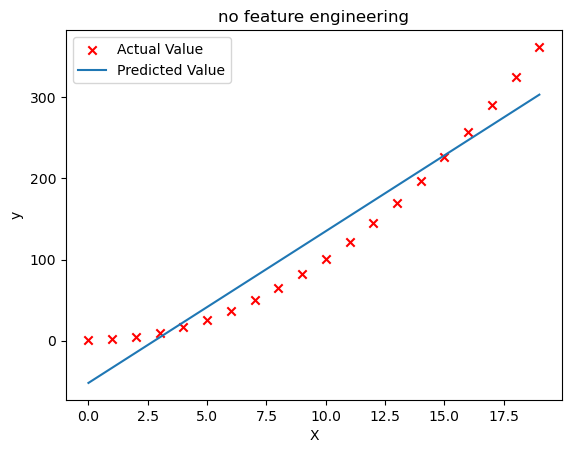

In [22]:
# 构造一个简单的多项式 y = 1+x**2

x = np.arange(0, 20, 1)
y = 1 + x**2
X = x.reshape(-1, 1)

model_w,model_b, _= gradient_descent(X,y,iterations=1000, alpha = 1e-2)

plt.scatter(x, y, marker='x', c='r', label="Actual Value")
plt.title("no feature engineering")
plt.plot(x,X@model_w + model_b, label="Predicted Value")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

如您所料，当前模型拟合效果并不好。我们需要的其实是类似

$$
y = w_0\,x_0^{\,2} + b
$$

这样的 **多项式特征**。
实现方式是对**输入数据进行特征工程**：把原始特征 $x$ 替换为 $x^{2}$。也就是说，只要把训练数据中的 `X` 换成 `X**2`，就能让模型学习到

$$
y = w_0\,x_0^{\,2} + b
$$

的关系。
下面尝试一下：在代码里把 `X` 替换为 `X**2`。

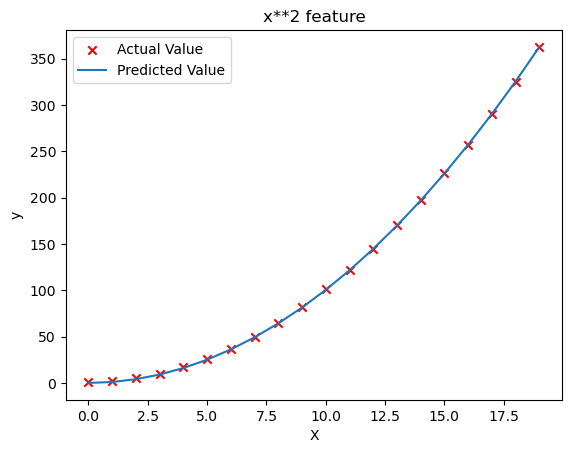

In [29]:
# 随堂练习：把上面的X换成X**2， 然后重新执行上个代码的流程：跑梯度下降得出参数，画图，得出如下图片：


在上面的例子里，我们知道需要加入 $x^2$ 项，但在实际问题中，并不总能一眼看出该添加哪些特征。通常可以一次性构造出多种候选特征，再通过训练筛选出最有用的。

举个例子：如果我们尝试这样的模型会怎样？

$$
y = w_0x_0 \;+\; w_1x_1^{\,2} \;+\; w_2x_2^{\,3} \;+\; b
$$


In [34]:
x = np.arange(0, 20, 1)
y = x**2

X = np.column_stack([x, x**2, x**3])  # np.c_[x, x**2, x**3]，np.vstack([x, x**2, x**3]).T可以达到一样的效果
print(X.shape)

(20, 3)


迭代    0 次：代价  1140.29
迭代 1000 次：代价   328.54
迭代 2000 次：代价   280.44
迭代 3000 次：代价   239.39
迭代 4000 次：代价   204.34
迭代 5000 次：代价   174.43
迭代 6000 次：代价   148.90
迭代 7000 次：代价   127.10
迭代 8000 次：代价   108.49
迭代 9000 次：代价    92.61


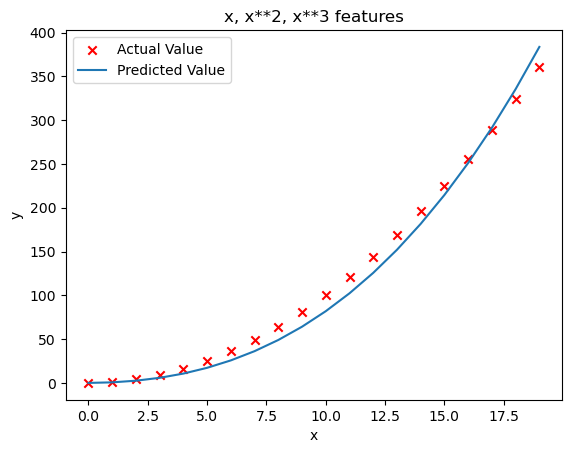

梯度下降找到的w，b分别是：w:[0.08 0.54 0.03], b:0.010561850529563571


In [37]:
model_w,model_b,_ = gradient_descent(X, y, iterations=10000, alpha=1e-7)

plt.scatter(x, y, marker='x', c='r', label="Actual Value")
plt.title("x, x**2, x**3 features")
plt.plot(x, X@model_w + model_b, label="Predicted Value")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

print(f"梯度下降找到的w，b分别是：w:{model_w}, b:{model_b}")

注意到训练后参数 $\mathbf{w} = [0.08,\; 0.54,\; 0.03]$，偏置 $b = 0.0106$。
这说明最终模型为

$$
0.08\,x \;+\; 0.54\,x^{2} \;+\; 0.03\,x^{3} \;+\; 0.0106
$$

在梯度下降过程中，算法通过**增大 $w_1$**、相对**减小 $w_0$ 与 $w_2$**，把重点放在最能拟合数据的 $x^{2}$ 项上。如果训练足够久，其余权重还会继续减小。

> **梯度下降会自动“挑选”合适的特征** —— 通过放大对应的参数、压低无用特征的参数。

**要点**

* 权重越小 → 该特征越不重要；若权重趋近于 0，则该特征几乎对模型无用。
* 在本例中，拟合后与 $x^{2}$ 对应的权重（0.54）远大于 $x$ 和 $x^{3}$ 的权重，说明 $x^{2}$ 最能帮助模型贴合数据。


- 另一种视角

在上文中，我们根据多项式特征是否能很好地拟合目标数据来挑选它们。换个角度看，一旦我们构造出新的特征，本质上仍在使用**线性回归**。既然如此，最优特征应当与目标变量呈“线性关系”。用一个具体示例来理解


In [38]:
x = np.arange(0, 20, 1)
y = x**2

# engineer features .
X = np.c_[x, x**2, x**3]   #<-- added engineered feature
X_features = ['x','x^2','x^3']

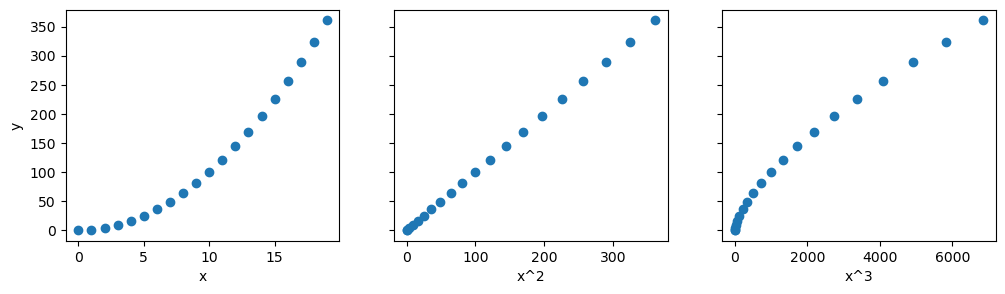

In [39]:
fig,ax=plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X[:,i],y)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("y")
plt.show()

从上面的结果可以清楚地看出，$\,x^{2}$ 特征与目标值 $y$ 呈线性关系，因此线性回归可以轻松利用这一特征来生成模型。

- 特征缩放

当数据集中各特征的数值范围差异很大时，应该进行特征缩放，以加快梯度下降的收敛速度。在前面的例子中，存在 $x$、$x^{2}$ 和 $x^{3}$ 三个特征，它们的量级天生相差悬殊。下面，我们就对这些特征应用 **Z‑score 标准化** 来做演示。


In [41]:
def zscore_normalize_features(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

In [46]:
x = np.arange(0,20,1)
y = x**2
X = np.c_[x, x**2, x**3]
print(f"列和列之间的峰值差（peak to peak）   原始的X:{np.ptp(X,axis=0)}")

# add mean_normalization
X = zscore_normalize_features(X)
print(f"列和列之间的峰值差（peak to peak），缩放后的 X:{np.ptp(X,axis=0)}")

列和列之间的峰值差（peak to peak）   原始的X:[  19  361 6859]
列和列之间的峰值差（peak to peak），缩放后的 X:[3.3  3.18 3.28]


迭代    0 次：代价  9421.47
迭代 10000 次：代价     0.39
迭代 20000 次：代价     0.03
迭代 30000 次：代价     0.00
迭代 40000 次：代价     0.00
迭代 50000 次：代价     0.00
迭代 60000 次：代价     0.00
迭代 70000 次：代价     0.00
迭代 80000 次：代价     0.00
迭代 90000 次：代价     0.00


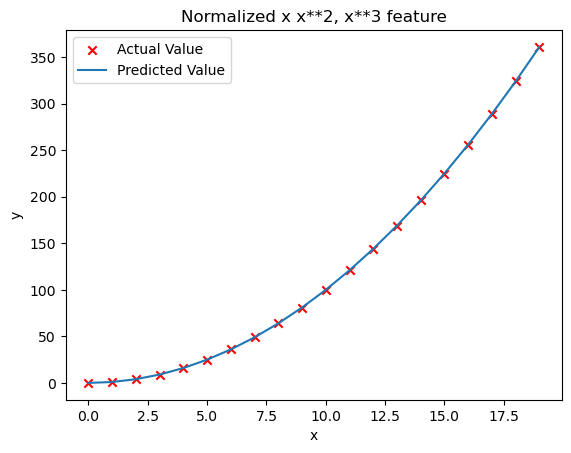

梯度下降找到的w，b分别是：w:[5.27e-05 1.13e+02 8.43e-05], b:123.49999999999994


In [47]:
# 现在梯度基本都一样小，可以用更大的学习率
model_w, model_b, _ = gradient_descent(X, y, iterations=100000, alpha=1e-1)

plt.scatter(x, y, marker='x', c='r', label="Actual Value")
plt.title("Normalized x x**2, x**3 feature")
plt.plot(x,X@model_w + model_b, label="Predicted Value")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

print(f"梯度下降找到的w，b分别是：w:{model_w}, b:{model_b}")

特征缩放使模型收敛速度显著提升。
再看一次参数向量 $\mathbf{w}$ 的数值：对应于 $x^{2}$ 项的 $w_1$ 最为突出，而梯度下降几乎将 $x^{3}$ 项的权重压到趋近于零。


- 复杂函数也能“线性”建模 —— 以 cos 函数的泰勒逼近为例

在特征工程的帮助下，即使原本高度非线性的目标函数，也可以转化为**线性回归**可处理的问题。方法就是：

1. **展开函数**（泰勒级数）；
2. **把展开式中的每一项当作一个特征**；
3. 用线性回归去学习这些特征的权重。

$$
\cos x \;=\; 1 \;-\; \frac{x^{2}}{2!} \;+\; \frac{x^{4}}{4!} \;-\; \frac{x^{6}}{6!} \;+\; \cdots
$$

迭代    0 次：代价     0.22
迭代 100000 次：代价     0.02
迭代 200000 次：代价     0.02
迭代 300000 次：代价     0.02
迭代 400000 次：代价     0.02
迭代 500000 次：代价     0.02
迭代 600000 次：代价     0.02
迭代 700000 次：代价     0.02
迭代 800000 次：代价     0.02
迭代 900000 次：代价     0.02


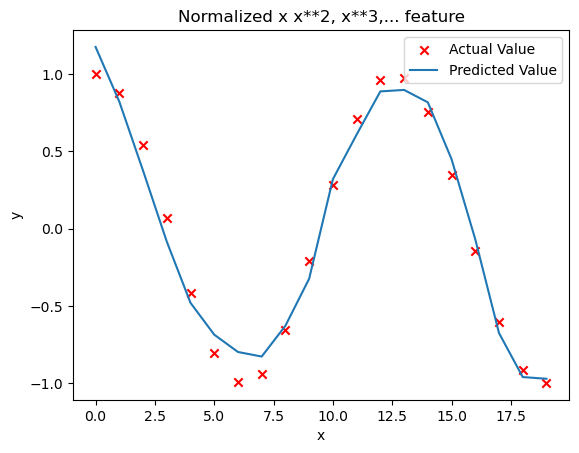

In [49]:
x = np.arange(0,20,1)
y = np.cos(x/2)

# 随堂练习：对x做特征工程，比如可以组合x，x**2，...到 x**15，利用梯度下降训练这些特征的参数，训练好后，看拟合的曲线是否接近np.cos(x/2）， （画散点+折线图）
